BDS^3 2024
=====

## Реконструкція біофізичних властивостей кальцій-зв'язуючих білків за результами конфокальної мікроскопії
---
_Borys Olifirov, 07.2024, Uzhhorod_

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import numpy as np
from numpy import ma

from skimage import io
from skimage import filters
from skimage import measure
from skimage import morphology

from scipy.ndimage import measurements
from scipy import signal

import sympy as sp

# 1. Біофізика процесу зв'язування іонів кальцію
---

## Зв'язування одного ліганду. Ізотерма Ленгмюра

Рівняння зв'язування білком __P__ одного ліганда __L__ (реакція другого порядку):
$$
P + L \rightleftharpoons PL
$$

Загальна концентрація білка (__[P]0__) та ліганда (__[L]0__) є сумої концентрації їх вільних (__[P]__, __[L]__) та зв'язаних (__[PL]__) форм:
$$
[P]_0 = [P] + [PL]
$$
$$
[L]_0 = [L] + [PL]
$$


$$
K_d = \frac{[P] \cdot [L]}{[PL]}
$$




In terms of the concentration of protein bounded form __[PL]__ or fraction of bound protein __Y__ we can rewrite the equation:
$$
Y = \frac{[PL]}{[P]_0}
$$

$$
[PL] = [P]_0 \frac{[L]}{K_d + [L]} \Leftrightarrow Y = \frac{[L]}{K_d + [L]} 
$$

           Cₗ  
Y(Cₗ) = ───────
        Cₗ + Kₐ


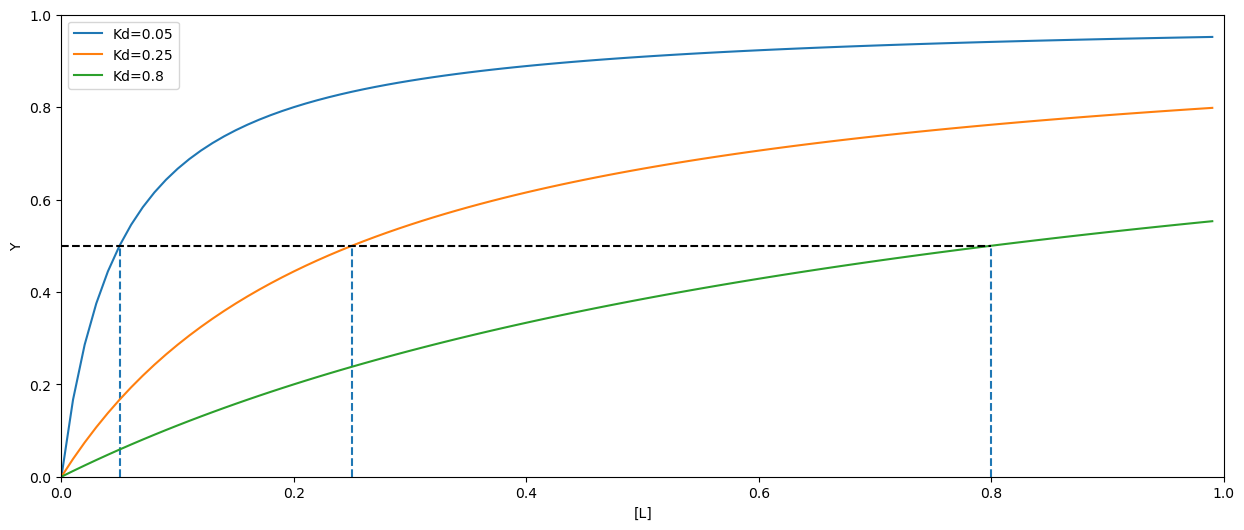

In [2]:
# параметри моделі
Kd_1_val = 0.05
Kd_2_val = 0.25
Kd_3_val = 0.8

c_l = np.arange(0, 1, 0.01)  # масив значень концентранції ліганда, від 0 до 1

# модель рівняння Ленгмюра
K_d, C_L = sp.symbols('K_a, C_l')
Y = sp.Function('Y')(C_L)
lang_eq = sp.Eq(Y, C_L/(C_L + K_d))

sp.pprint(lang_eq)

lang_eq_sol_Kd_1 = sp.lambdify(C_L, lang_eq.subs({K_d: Kd_1_val}).rhs, 'numpy') 
lang_eq_sol_Kd_2 = sp.lambdify(C_L, lang_eq.subs({K_d: Kd_2_val}).rhs, 'numpy') 
lang_eq_sol_Kd_3 = sp.lambdify(C_L, lang_eq.subs({K_d: Kd_3_val}).rhs, 'numpy') 

# відображення графіків
plt.figure(figsize=(15,6))
plt.plot(c_l, lang_eq_sol_Kd_1(c_l), label=f'Kd={Kd_1_val}')
plt.vlines(x=Kd_1_val, ymin=0, ymax=0.5, linestyles='--')

plt.plot(c_l, lang_eq_sol_Kd_2(c_l), label=f'Kd={Kd_2_val}')
plt.vlines(x=Kd_2_val, ymin=0, ymax=0.5, linestyles='--')

plt.plot(c_l, lang_eq_sol_Kd_3(c_l), label=f'Kd={Kd_3_val}')
plt.vlines(x=Kd_3_val, ymin=0, ymax=0.5, linestyles='--')

plt.hlines(y=0.5, xmin=0, xmax=Kd_3_val, linestyles='--', color='k')

plt.xlim([0, 1])
plt.xlabel('[L]')

plt.ylim([0, 1])
plt.ylabel('Y')

plt.legend()
plt.show()

## Зв'язування декілької лігандів та кооперетивність. Рівняння Хіла

$$
Y = \frac{[L]^h}{K_d + [L]^h} = \frac{[L]^h}{K_A^n + [L]^h}
$$

$$
\log(\frac{Y}{1-Y}) = h \log[L] + \log K_A
$$

                 h   
             Cᵢₒₙ    
Y(Cᵢₒₙ) = ───────────
              h     h
          Cᵢₒₙ  + Kₐ 
   ⎛  Y(Cᵢₒₙ)  ⎞                        
log⎜───────────⎟ = h⋅log(Cᵢₒₙ) + log(Kₐ)
   ⎝1 - Y(Cᵢₒₙ)⎠                        


<lambdifygenerated-5>:2: RuntimeWarning: divide by zero encountered in log
  return log(C_ion) - 1.38629436111989
<lambdifygenerated-7>:2: RuntimeWarning: divide by zero encountered in log
  return 1.5*log(C_ion) - 1.38629436111989
<lambdifygenerated-9>:2: RuntimeWarning: divide by zero encountered in log
  return 2*log(C_ion) - 1.38629436111989
<lambdifygenerated-11>:2: RuntimeWarning: divide by zero encountered in log
  return 5*log(C_ion) - 1.38629436111989


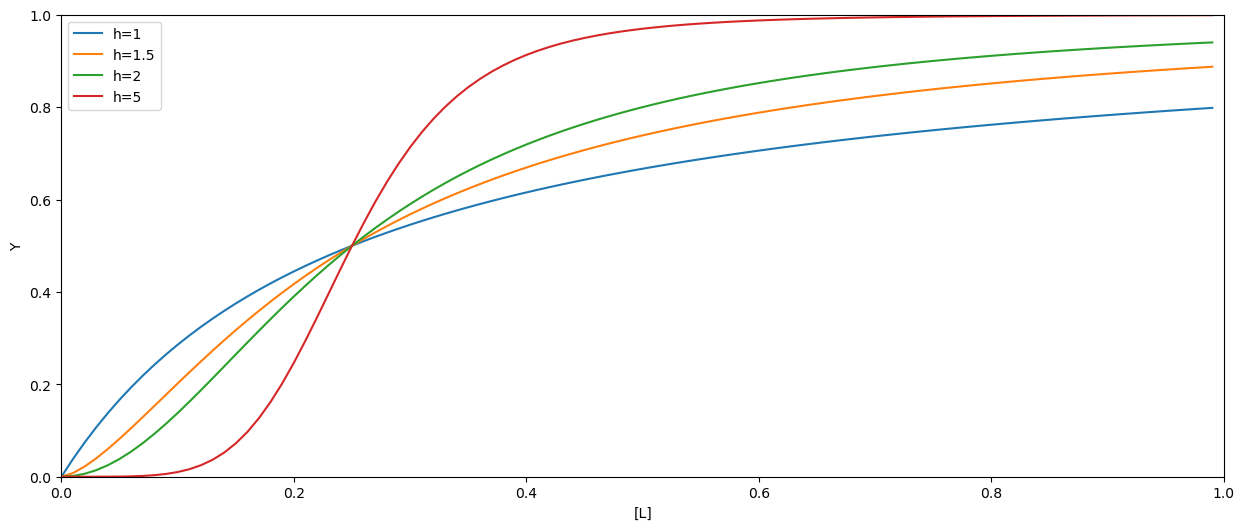

In [3]:
# c_l = np.arange(0, 1, 0.01)
h_list = [1, 1.5, 2, 5]
K_A_val = 0.25

h, K_A, C_L = sp.symbols('h  K_a C_ion')
Y = sp.Function('Y')(C_L)
hill_eq = sp.Eq(Y, C_L**h/(K_A**h + C_L**h))
hill_eq_ln = sp.Eq(sp.log(Y/(1-Y)), h * sp.log(C_L) + sp.log(K_A))

sp.pprint(hill_eq, use_unicode=True)
sp.pprint(hill_eq_ln, use_unicode=True)

hill_profiles_dict = {}
hill_ln_dict = {}
for h_val in h_list:
	hill_eq_sol = sp.lambdify(C_L, hill_eq.subs({h : h_val, K_A : 0.25}).rhs, "numpy")
	hill_ln_sol = sp.lambdify(C_L, hill_eq_ln.subs({h : h_val, K_A : 0.25}).rhs, "numpy")
	hill_profiles_dict.update({h_val:hill_eq_sol(c_l)})
	hill_ln_dict.update({h_val:hill_ln_sol(c_l)})

# відображення графіків
plt.figure(figsize=(15,6))
for h_prof in hill_profiles_dict.keys():
	plt.plot(c_l, hill_profiles_dict[h_prof], label=f'h={h_prof}')

plt.xlim([0, 1])
plt.xlabel('[L]')

plt.ylim([0, 1])
plt.ylabel('Y')

plt.legend()
plt.show()

# plt.figure(figsize=(15,6))
# for h_prof in hill_ln_dict.keys():
# 	plt.plot(c_l, hill_ln_dict[h_prof], label=f'h={h_prof}')

# plt.xlabel('log([L])')
# plt.ylabel('log(Y/(1-Y))')

# plt.legend()
# plt.show()

# 2. Багатовимірні массиви та структура мікроскопічних даних
---

## Приклади

- Розмірність масивів
- Індексація та слайсинг
- Виконання функцій вздовж вісей (mean, max etc.)
- Серія зображень як масив
- Виведення зображень
- Палітри (cmap)

## Аналіз даних

#### Завантаження зображень та розділення каналів

In [5]:
# завантаження зображень
img_raw = io.imread("data/cell6.tif")
print(img_raw.shape)


# розділення окремих каналів
ch0_img_raw = img_raw[0]
ch1_img_raw = img_raw[1]
print(ch0_img_raw.shape) 

(2, 30, 256, 256)
(30, 256, 256)


#### Проекції серії знімків

Проекція максимальної інтенсивності пікселів

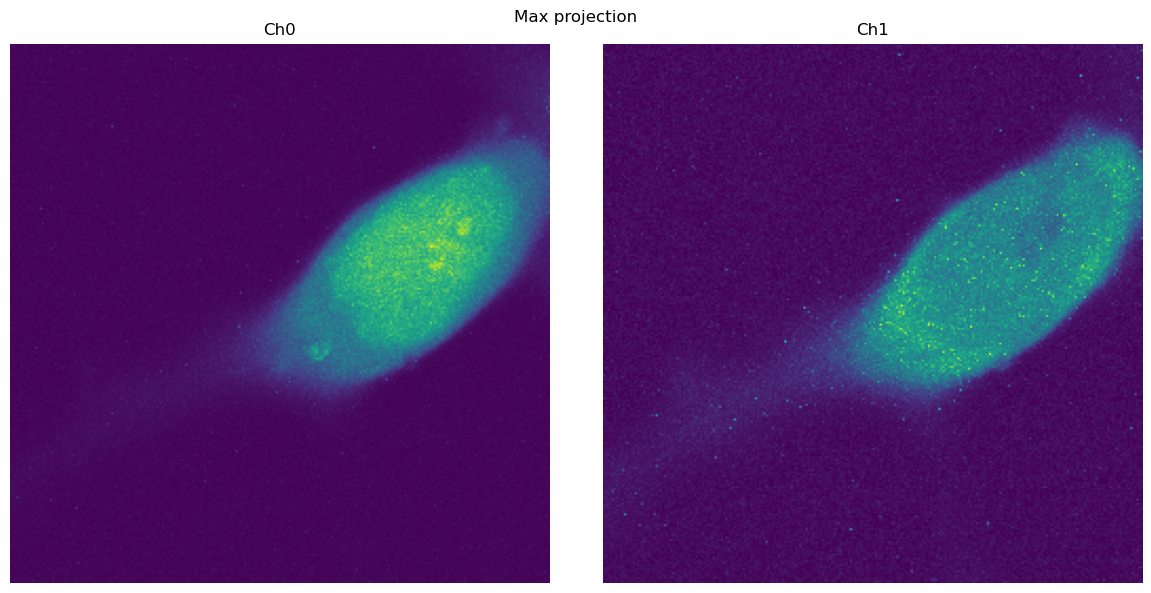

In [6]:
# проекції максимума для окремих каналів
ch0_img_raw_max = np.max(ch0_img_raw, axis=0)
ch1_img_raw_max = np.max(ch1_img_raw, axis=0)


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # зображення каналу 1
ax0.imshow(ch0_img_raw_max)
ax0.set_title('Ch0')
ax0.axis('off')

ax1 = plt.subplot(122)  # зображення каналу 2
ax1.imshow(ch1_img_raw_max)
ax1.set_title('Ch1')
ax1.axis('off')

plt.suptitle('Max projection')
plt.tight_layout()
plt.show()

Проекція середньої інтенсивності пікселів

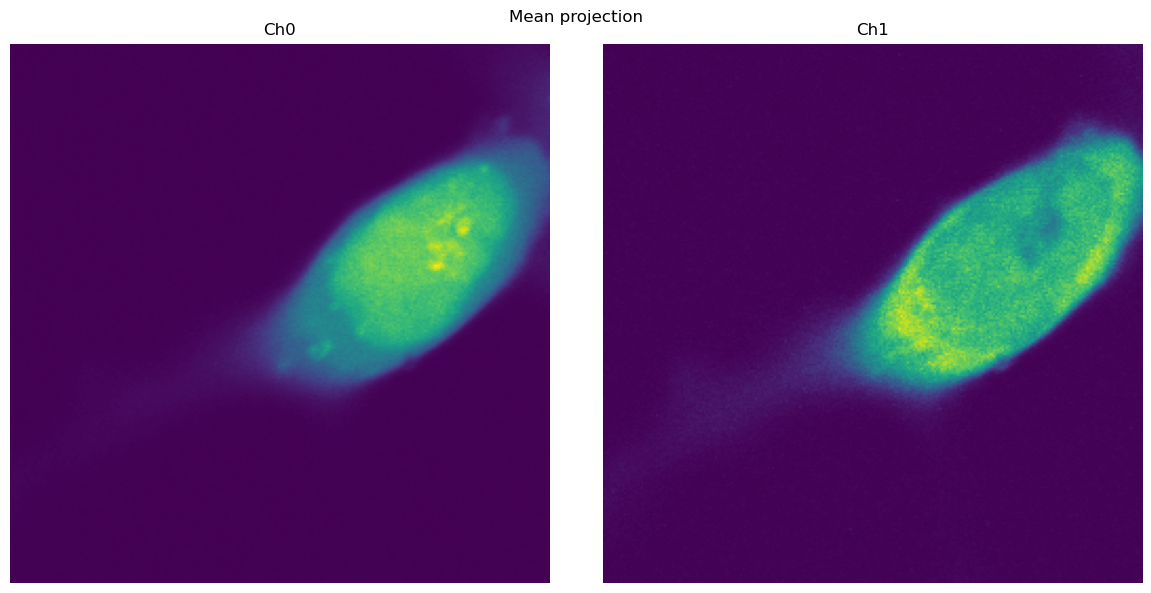

In [7]:
# проекції максимума для окремих каналів
ch0_img_raw_mean = np.mean(ch0_img_raw, axis=0)
ch1_img_raw_mean = np.mean(ch1_img_raw, axis=0)


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # зображення каналу 1
ax0.imshow(ch0_img_raw_mean)
ax0.set_title('Ch0')
ax0.axis('off')

ax1 = plt.subplot(122)  # зображення каналу 2
ax1.imshow(ch1_img_raw_mean)
ax1.set_title('Ch1')
ax1.axis('off')

plt.suptitle('Mean projection')
plt.tight_layout()
plt.show()

#### Кроп серії зображення

Вибір регіону клітини в кадрі

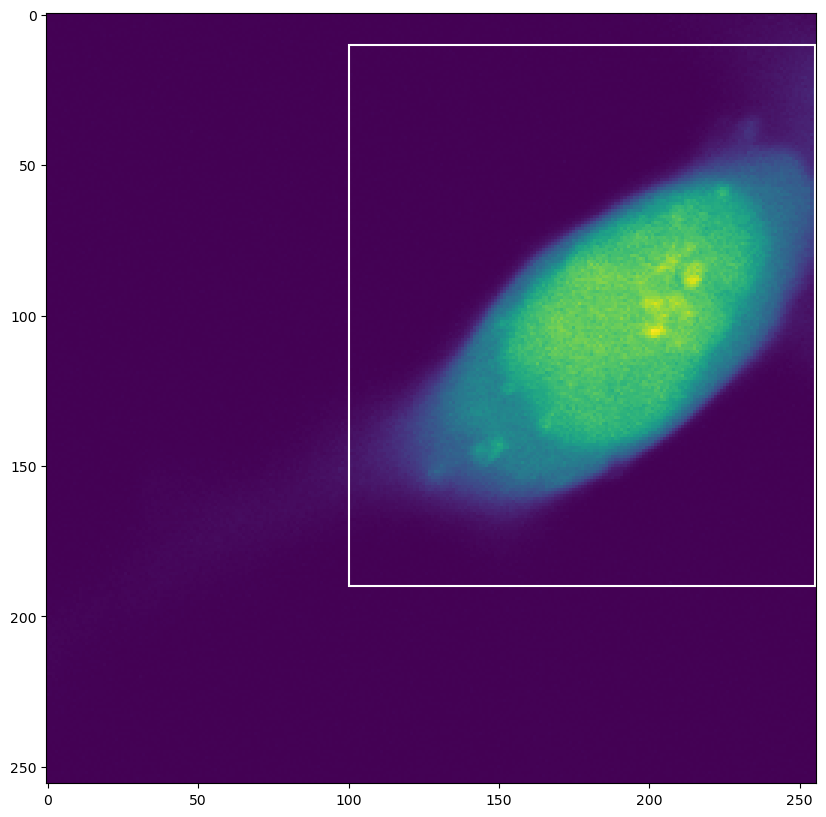

In [8]:
# регіон кропу
x_start, x_end, y_start, y_end = 10, 180, 100, 155  # для файлу cell6
# x_start, x_end, y_start, y_end = 40, 200, 100, 120  # для файлу cell7

crop_rect = patches.Rectangle((y_start, x_start), y_end, x_end,
                              linewidth=1.5, edgecolor='white', facecolor='none')

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(ch0_img_raw_mean)
ax.add_patch(crop_rect)
plt.show()

Кроп всієї серії зображень для кожного з каналів

(30, 180, 155)


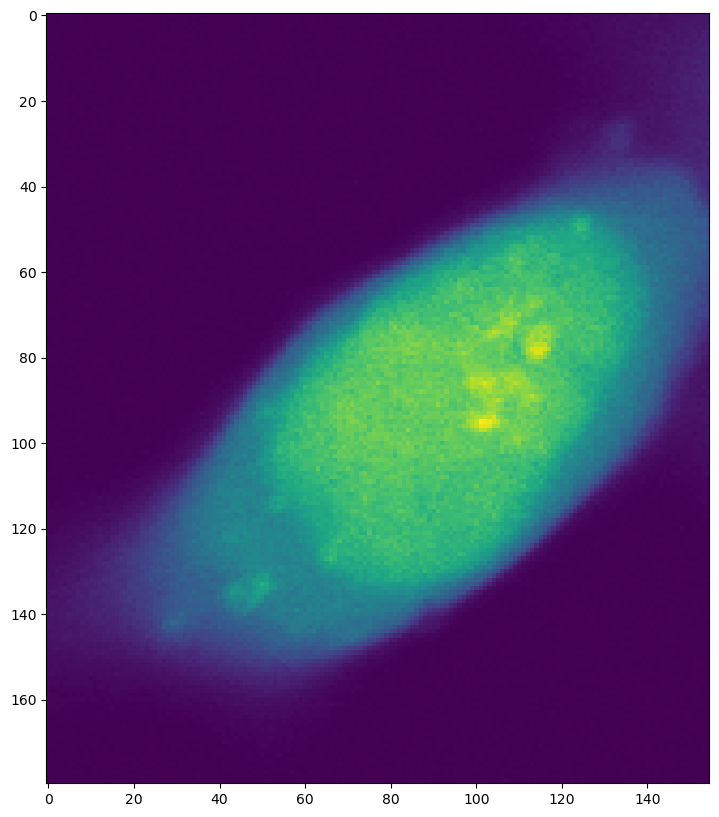

In [9]:
ch0_img_raw_crop = ch0_img_raw[:, x_start:x_start+x_end, y_start:y_start+y_end]
ch1_img_raw_crop = ch1_img_raw[:, x_start:x_start+x_end, y_start:y_start+y_end]
print(ch0_img_raw_crop.shape)


# plot
plt.figure(figsize=(10,10))
plt.imshow(np.mean(ch0_img_raw_crop, axis=0))
plt.show()

# 3. Фільтри, маски та морфологічні оператори
---

## Приклади

- Стркуктурний елемент
- Згортка
- Медіанний фільтр та фільтр Гаусу
- Фіксований поріг та булева маска
- Гістограма зображення, метод Отсу
- Ерозія та діляція
- Відкривання та закривання

## Аналіз даних

#### Детекція та сегментація клітини з використанням мульти-Отсу

"Контрольне" зображення для детекції клітини

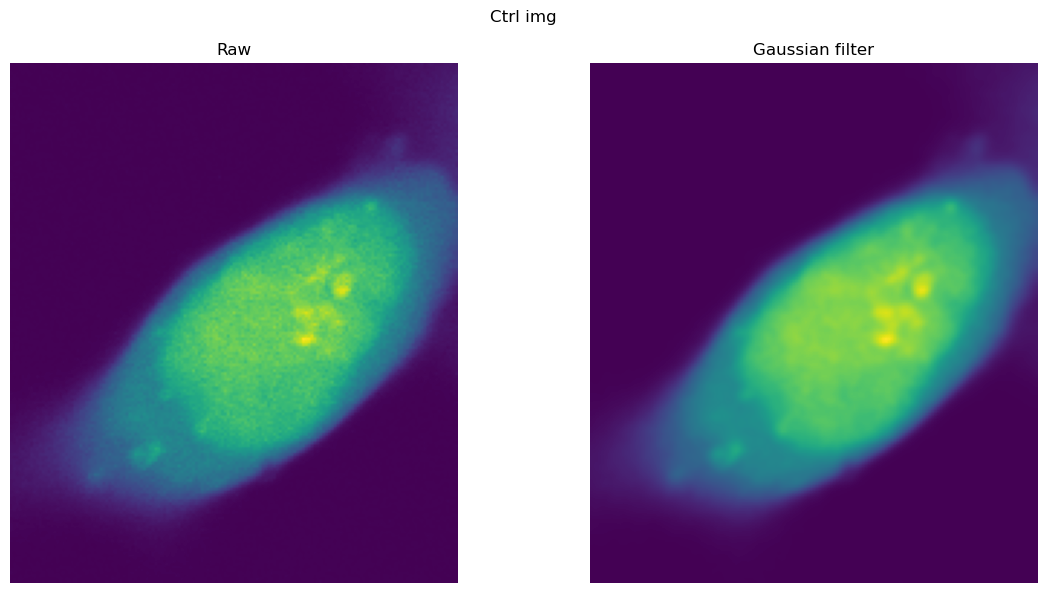

In [10]:
# контрольне зображення для детекції
cell_det_img_raw = np.mean(ch0_img_raw_crop, axis=0)

# фільтрування контрольного зображення
cell_det_img = filters.gaussian(cell_det_img_raw, sigma=1)


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # сире контрольне зображення
ax0.imshow(cell_det_img_raw)
ax0.set_title('Raw')
ax0.axis('off')

ax1 = plt.subplot(122)  # контрольне зображення після застосування фільтра Гауса
ax1.imshow(cell_det_img)
ax1.set_title('Gaussian filter')
ax1.axis('off')

plt.suptitle('Ctrl img')
plt.tight_layout()
plt.show()

Обчислення порогів мульти-Отсу

[ 555.46190739 1261.86700766]


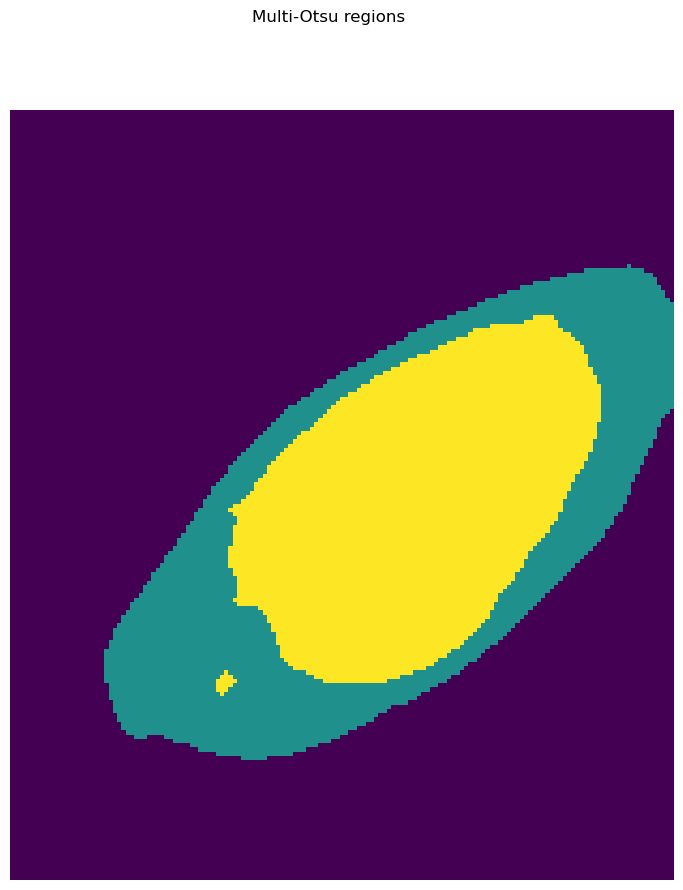

In [11]:
# отримання порогів мульти-Отсу
thresholds = filters.threshold_multiotsu(cell_det_img)
print(thresholds)

# розмежування регіонів за пороговими значеннями
regions_img = np.digitize(cell_det_img, bins=thresholds)


# plot
plt.figure(figsize=(10,10))
plt.imshow(regions_img)  # регіони за порогами мульти-Отсу
plt.suptitle('Multi-Otsu regions')
plt.axis('off')
plt.show()

Побудова масок окремих регіонів

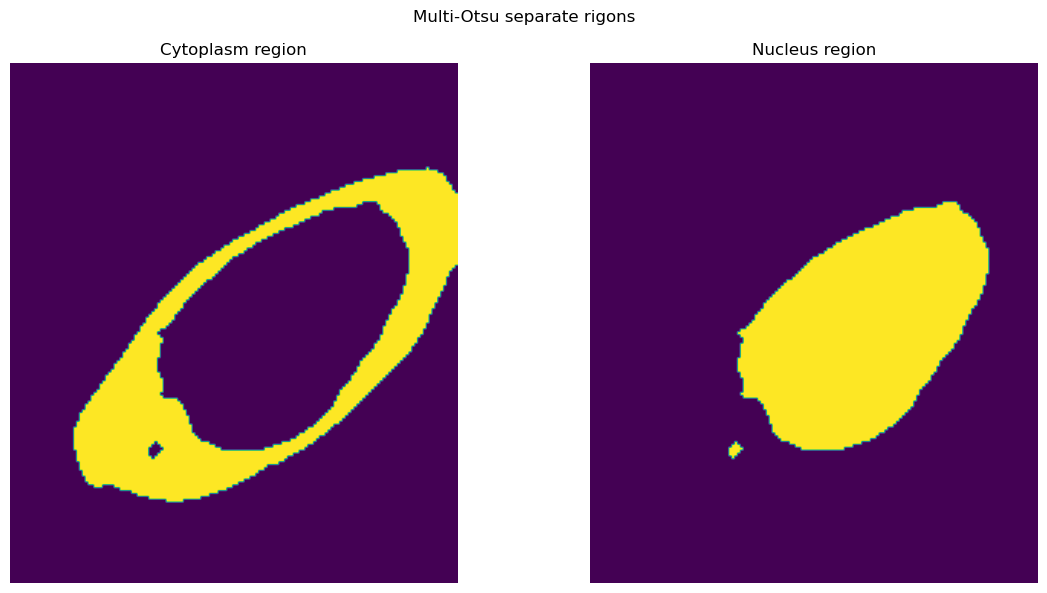

In [12]:
# булеві маски окремих регіонів
cytoplasm_mask_raw = regions_img == 1
nucleus_mask_raw = regions_img == 2


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # регіон цитоплазми
ax0.imshow(cytoplasm_mask_raw)
ax0.set_title('Cytoplasm region')
ax0.axis('off')

ax1 = plt.subplot(122)  # регіон ядра
ax1.imshow(nucleus_mask_raw)
ax1.set_title('Nucleus region')
ax1.axis('off')

plt.suptitle('Multi-Otsu separate rigons')
plt.tight_layout()
plt.show()

#### Побудова масок цитоплазматичного регіону клітини та цілої клітини

Модифікація регіонів

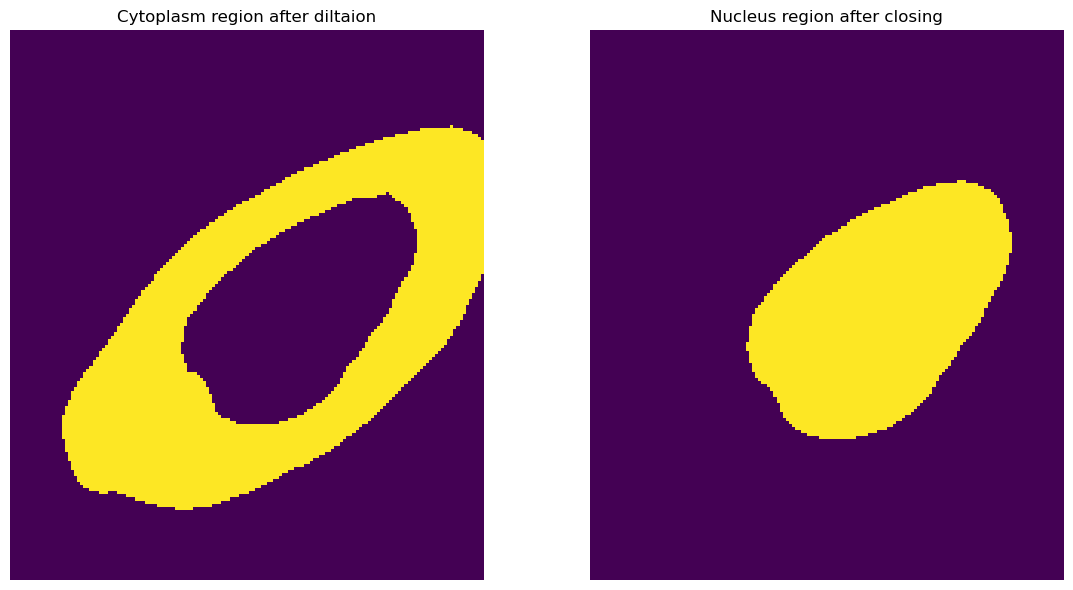

In [13]:
cytoplasm_mask = morphology.dilation(cytoplasm_mask_raw, footprint=morphology.disk(5))
nucleus_mask = morphology.opening(nucleus_mask_raw, footprint=morphology.disk(10))


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # регіон цитоплазми
ax0.imshow(cytoplasm_mask)
ax0.set_title('Cytoplasm region after diltaion')
ax0.axis('off')

ax1 = plt.subplot(122)  # "роздутий" регіон цитоплазми
ax1.imshow(nucleus_mask)
ax1.set_title('Nucleus region after closing')
ax1.axis('off')

plt.tight_layout()
plt.show()

Корегування фінальної маски цитоплазматичного регіону та побудова маски цілої клітини

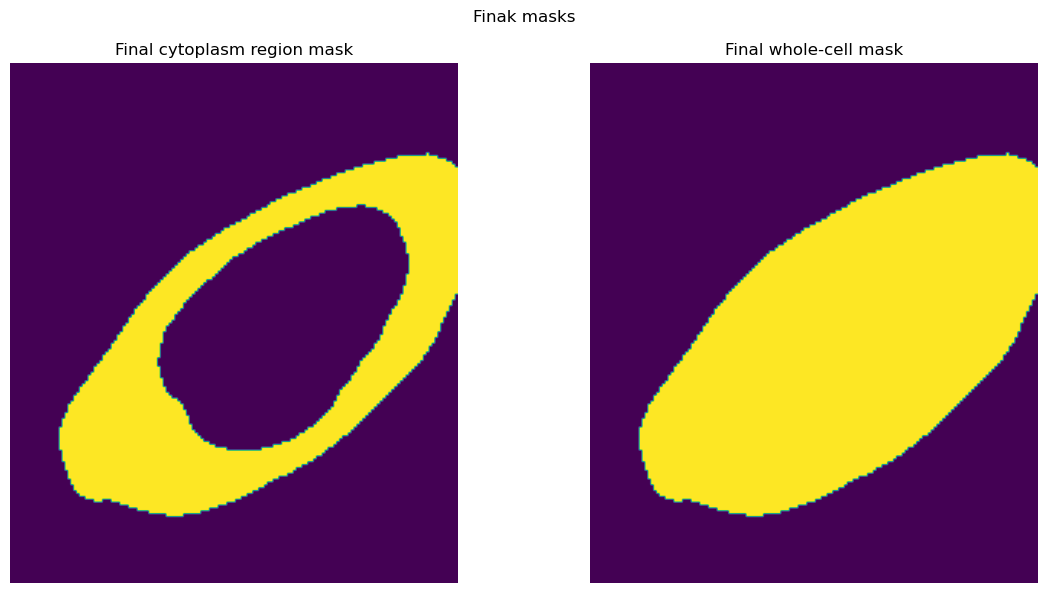

In [14]:
cytoplasm_mask[nucleus_mask] = 0
cell_mask = cytoplasm_mask + nucleus_mask


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # маска цитоплазматичног регіона
ax0.imshow(cytoplasm_mask)
ax0.set_title('Final cytoplasm region mask')
ax0.axis('off')

ax1 = plt.subplot(122)  # маска цілої клітини
ax1.imshow(cell_mask)
ax1.set_title('Final whole-cell mask')
ax1.axis('off')

plt.suptitle('Finak masks')
plt.tight_layout()
plt.show()

#### Фільтрування серій зображень обох каналів перед подальшою обробкою

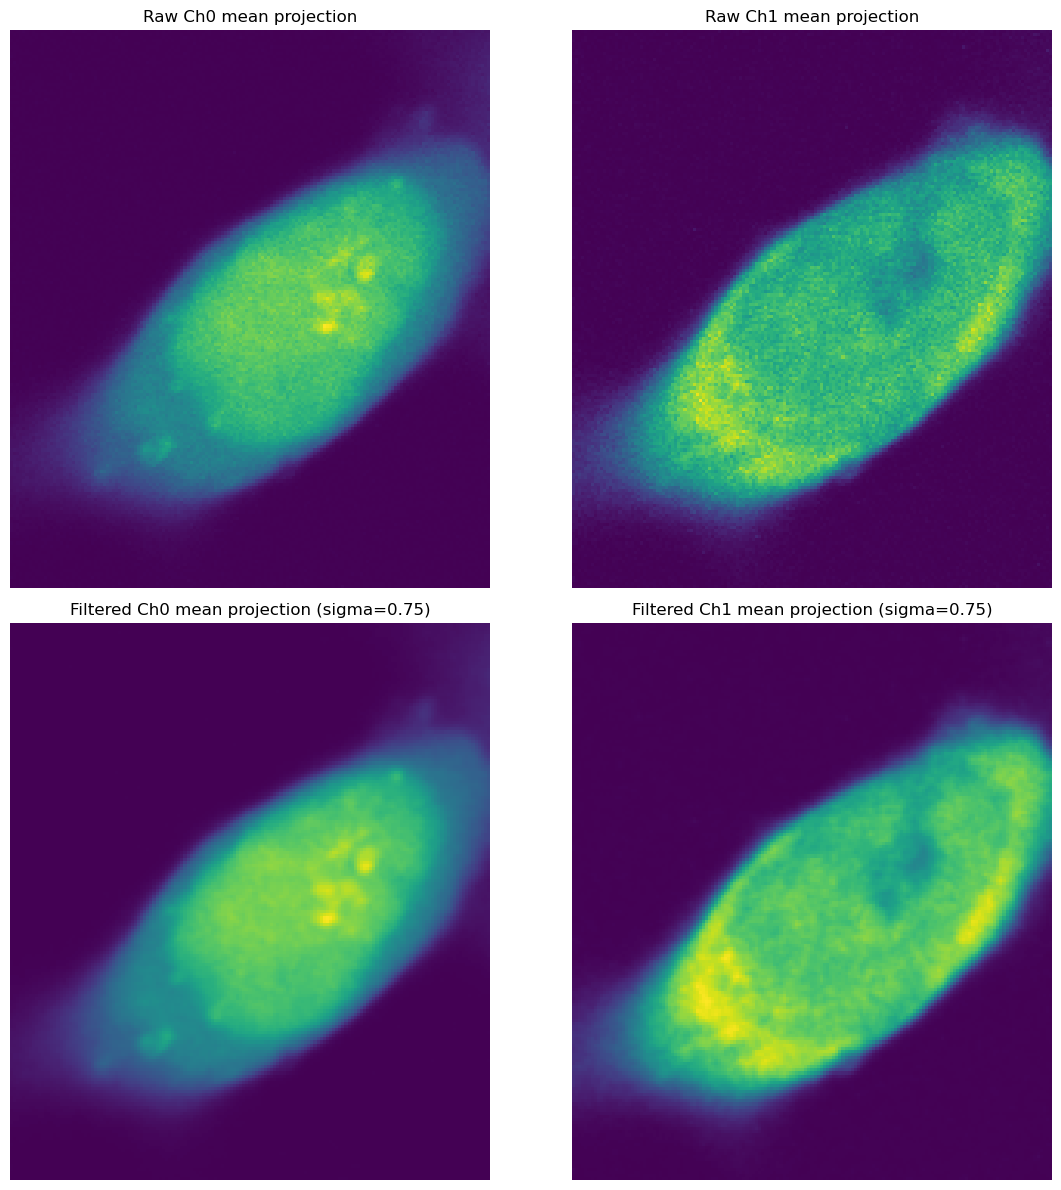

In [15]:
sigma = 0.75  # значення середньоквадратичного відхилення для фільтра Гауса
ch0_img_filtered = filters.gaussian(ch0_img_raw_crop, sigma=sigma, channel_axis=0)
ch1_img_filtered = filters.gaussian(ch1_img_raw_crop, sigma=sigma, channel_axis=0)


# plot
plt.figure(figsize=(12,12))

ax0 = plt.subplot(221)  # проекція середньої інтенсивності сирої серії зображень канала кальцієвого барвника
ax0.imshow(np.mean(ch0_img_raw_crop, axis=0))
ax0.set_title('Raw Ch0 mean projection')
ax0.axis('off')

ax1 = plt.subplot(222)  # проекція середньої інтенсивності сирої серії зображень канала флуоресцентного білка
ax1.imshow(np.mean(ch1_img_raw_crop, axis=0))
ax1.set_title('Raw Ch1 mean projection')
ax1.axis('off')

ax2 = plt.subplot(223)  # проекція середньої інтенсивності серії зображень канала кальцієвого барвника після фільтрування
ax2.imshow(np.mean(ch0_img_filtered, axis=0))
ax2.set_title(f'Filtered Ch0 mean projection (sigma={sigma})')
ax2.axis('off')

ax3 = plt.subplot(224)  # проекція середньої інтенсивності серії зображень канала флуоресцентного білка після фільтрування
ax3.imshow(np.mean(ch1_img_filtered, axis=0))
ax3.set_title(f'Filtered Ch1 mean projection (sigma={sigma})')
ax3.axis('off')

plt.tight_layout()
plt.show()

# 4. Детекція регіонів зміни інтенсивності
---

## Приклади

- Маскування з використанням ma
- Нормалізація та нормування
- Одновимірні масиви, findpeaks

## Аналіз даних

#### Побудова профілів похідної інтенсивності та визначення кадрів із стимуляціями 

Профіль загальної інтенсивності в кадрі та профіль похідної інтенсивності для каналу кальцієвого барвника

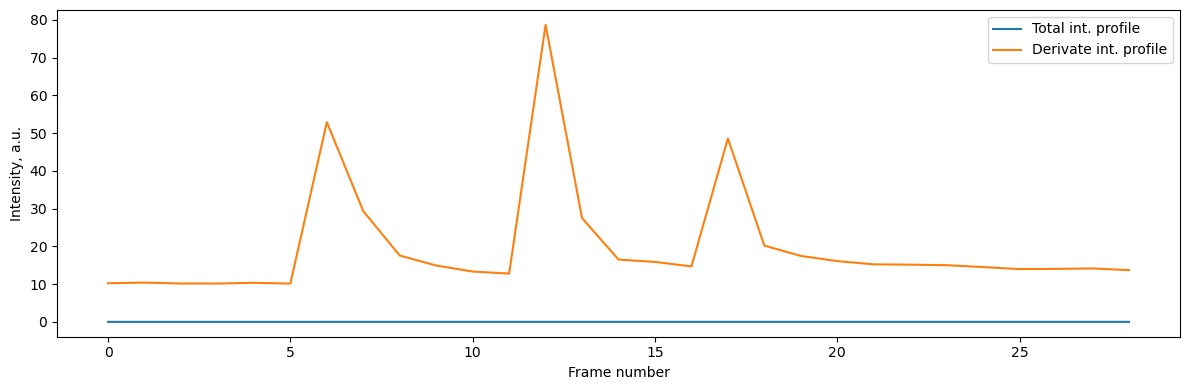

In [16]:
ch0_tot_prof = np.mean(ch0_img_filtered, axis=(1,2))  # профіль середньої інтенсивності кадра для канала 0

ch0_der_prof = np.asarray([np.sum(np.abs(ma.masked_where(~cell_mask, frame)))
                           for frame in (ch0_img_filtered[:-1] - ch0_img_filtered[1:])])  # профіль похідної інтенсивності для канала 0


# plot
plt.figure(figsize=(12, 4))

plt.plot(ch0_tot_prof[1:], label='Total int. profile')  # профіль середньої інтенсивності кадра для канала 0
plt.plot(ch0_der_prof, label='Derivate int. profile') # профіль похідної інтенсивності для канала 0

plt.xlabel('Frame number')
plt.ylabel('Intensity, a.u.')

plt.legend()
plt.tight_layout()
plt.show()

Нормалізація профілів каналу кальцієвого барвника

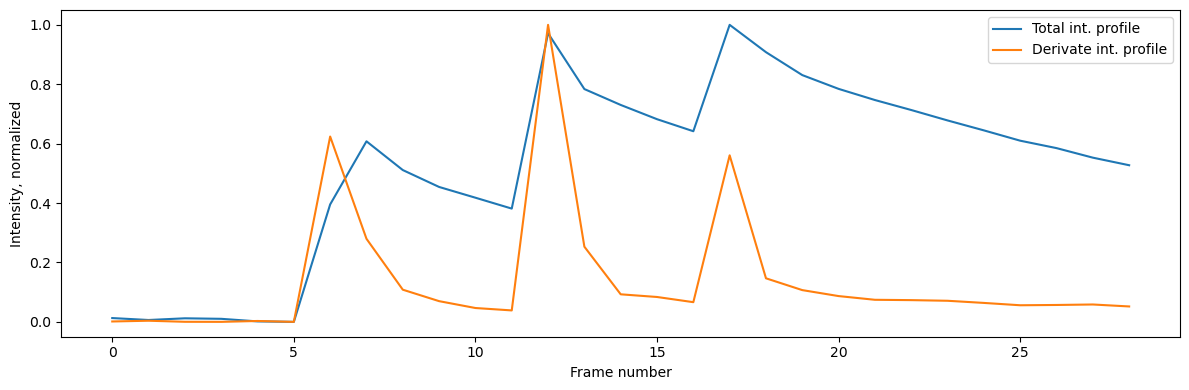

In [17]:
ch0_tot_prof_norm = (ch0_tot_prof - np.min(ch0_tot_prof))/(np.max(ch0_tot_prof)-np.min(ch0_tot_prof))
ch0_der_prof_norm = (ch0_der_prof - np.min(ch0_der_prof))/(np.max(ch0_der_prof)-np.min(ch0_der_prof))


# plot
plt.figure(figsize=(12, 4))

plt.plot(ch0_tot_prof_norm[1:], label='Total int. profile')  # профіль середньої інтенсивності кадра для канала 0
plt.plot(ch0_der_prof_norm, label='Derivate int. profile') # профіль похідної інтенсивності для канала 0

plt.xlabel('Frame number')
plt.ylabel('Intensity, normalized')

plt.legend()
plt.tight_layout()
plt.show()

Детекція піків зміни інтенсивносі кальцієвого барвника

Derivate calcium dye profile peals index: [ 6 12 17]


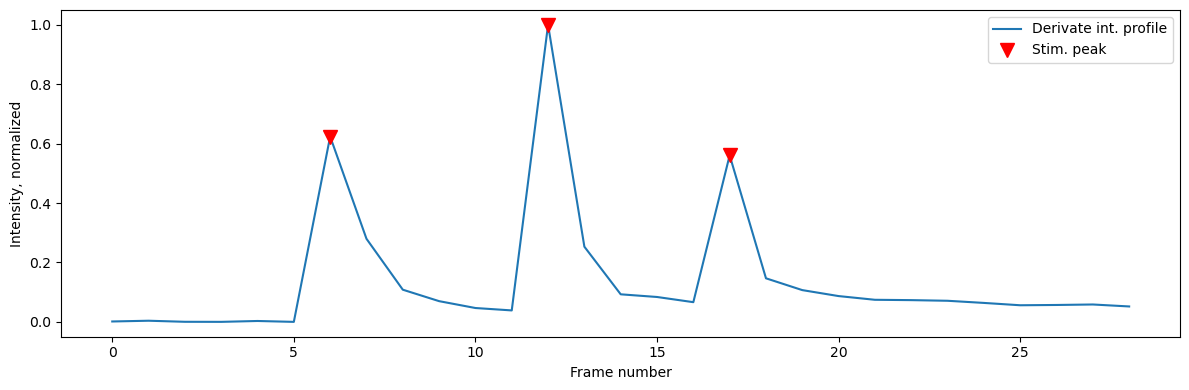

In [18]:
stim_peaks_idx, stim_peaks_prop = signal.find_peaks(ch0_der_prof_norm, height=0.25, distance=5)
print(f'Derivate calcium dye profile peals index: {stim_peaks_idx}')


# plot
plt.figure(figsize=(12, 4))

plt.plot(ch0_der_prof_norm, label='Derivate int. profile') # профіль похідної інтенсивності для канала 0
plt.plot(stim_peaks_idx, ch0_der_prof_norm[stim_peaks_idx],
         'v', label='Stim. peak', markersize=10, color='red')  # положення детектованих піків стимуляції

plt.xlabel('Frame number')
plt.ylabel('Intensity, normalized')

plt.legend()
plt.tight_layout()
plt.show()

#### Створення диференційних зображень транслокації

Створення контрольних зображень транслокацій

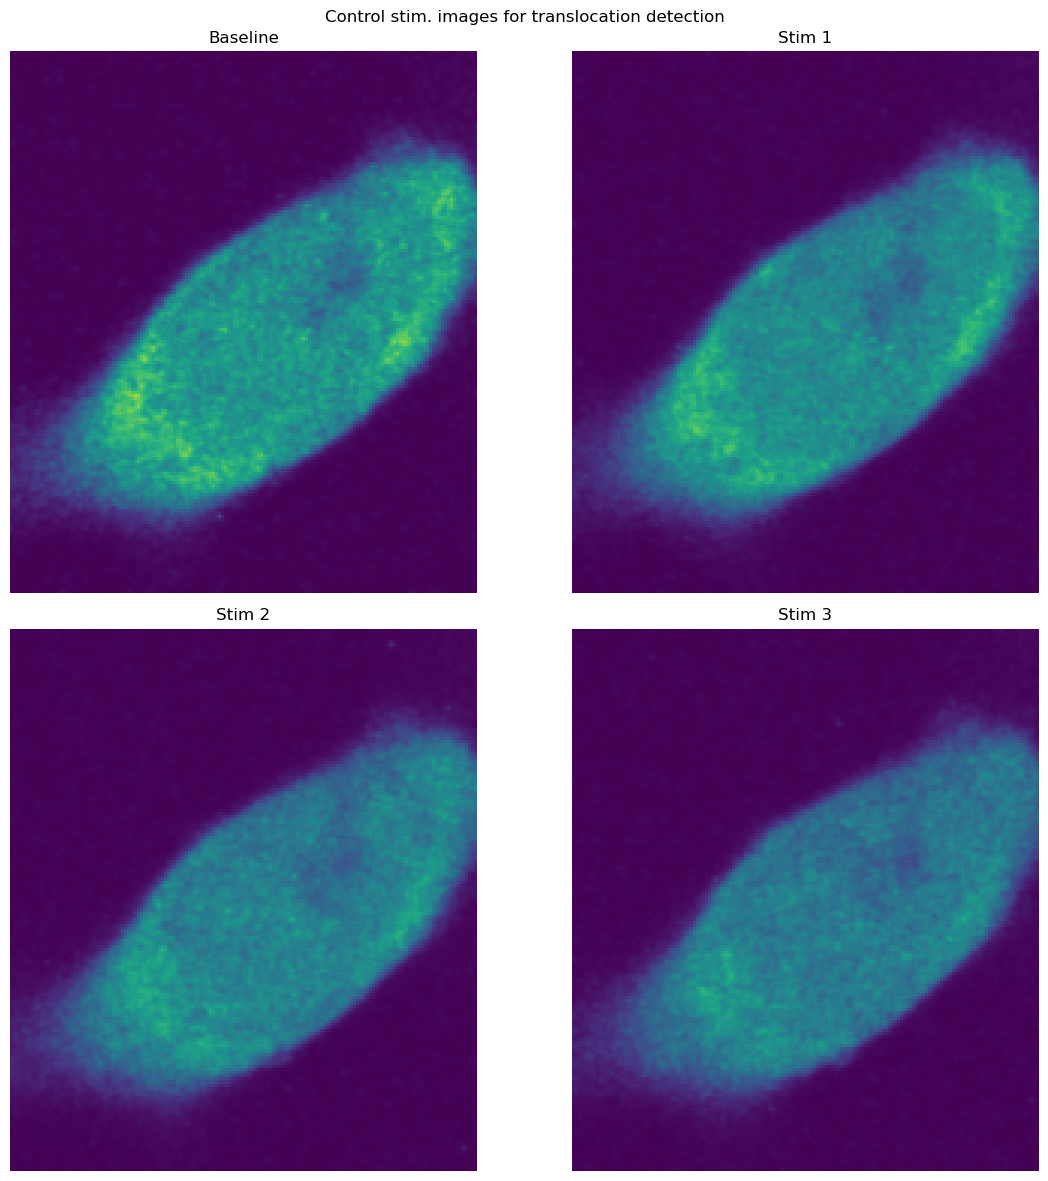

In [19]:
base_win = 2  # кількість кадрів для отримання контрольного зображення базової інтенсивності
stim_win = 3  # кількість зоборажень для отриамння контрольного зображення після стимуляції

# обчислення меж інтенсивності серії зображень в каналі флуоресцентного білка
int_lim_min, int_lim_max = np.min(ch1_img_filtered), np.max(ch1_img_filtered)

# обчислення контрольних зображень базової інтенсивності та після кожної стимуляції
fp_base = np.mean(ch1_img_filtered[:base_win], axis=0)  # базова інтенсивність
fp_stm1 = np.mean(ch1_img_filtered[stim_peaks_idx[0]:stim_peaks_idx[0]+stim_win], axis=0)  # стимуляція 1 
fp_stm2 = np.mean(ch1_img_filtered[stim_peaks_idx[1]:stim_peaks_idx[1]+stim_win], axis=0)  # стимуляція 2
fp_stm3 = np.mean(ch1_img_filtered[stim_peaks_idx[2]:stim_peaks_idx[2]+stim_win], axis=0)  # стимуляція 3


# plot
plt.figure(figsize=(12,12))

ax0 = plt.subplot(221)
ax0.imshow(fp_base, vmin=int_lim_min, vmax=int_lim_max)
ax0.set_title('Baseline')
ax0.axis('off')

ax1 = plt.subplot(222)
ax1.imshow(fp_stm1, vmin=int_lim_min, vmax=int_lim_max)
ax1.set_title('Stim 1')
ax1.axis('off')

ax2 = plt.subplot(223)
ax2.imshow(fp_stm2, vmin=int_lim_min, vmax=int_lim_max)
ax2.set_title(f'Stim 2')
ax2.axis('off')

ax3 = plt.subplot(224)
ax3.imshow(fp_stm3, vmin=int_lim_min, vmax=int_lim_max)
ax3.set_title(f'Stim 3')
ax3.axis('off')

plt.suptitle('Control stim. images for translocation detection')
plt.tight_layout()
plt.show()

Створення диференційних зображень відповіді на кожну стимуляцію

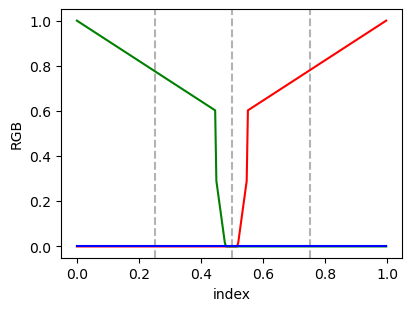

In [20]:
# red-green cmap creation
dict_red_green = {'red':(
                   (0.0, 0.0, 0.0),
                   (0.52, 0.0, 0.0),
                   (0.55, 0.3, 0.6),
                   (1.0, 1.0, 1.0)),
                   'blue':(
                   (0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
                   'green':(
                   (0.0, 1.0, 1.0),
                   (0.45, 0.6, 0.3),
                   (0.48, 0.0, 0.0),
                   (1.0, 0.0, 0.0))}
cmap_red_green = LinearSegmentedColormap('RedGreen', dict_red_green)


def plot_linearmap(cdict):
    newcmp = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)
    rgba = newcmp(np.linspace(0, 1, 256))
    fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)
    col = ['r', 'g', 'b']
    for xx in [0.25, 0.5, 0.75]:
        ax.axvline(xx, color='0.7', linestyle='--')
    for i in range(3):
        ax.plot(np.arange(256)/256, rgba[:, i], color=col[i])
    ax.set_xlabel('index')
    ax.set_ylabel('RGB')
    plt.show()
plot_linearmap(dict_red_green)

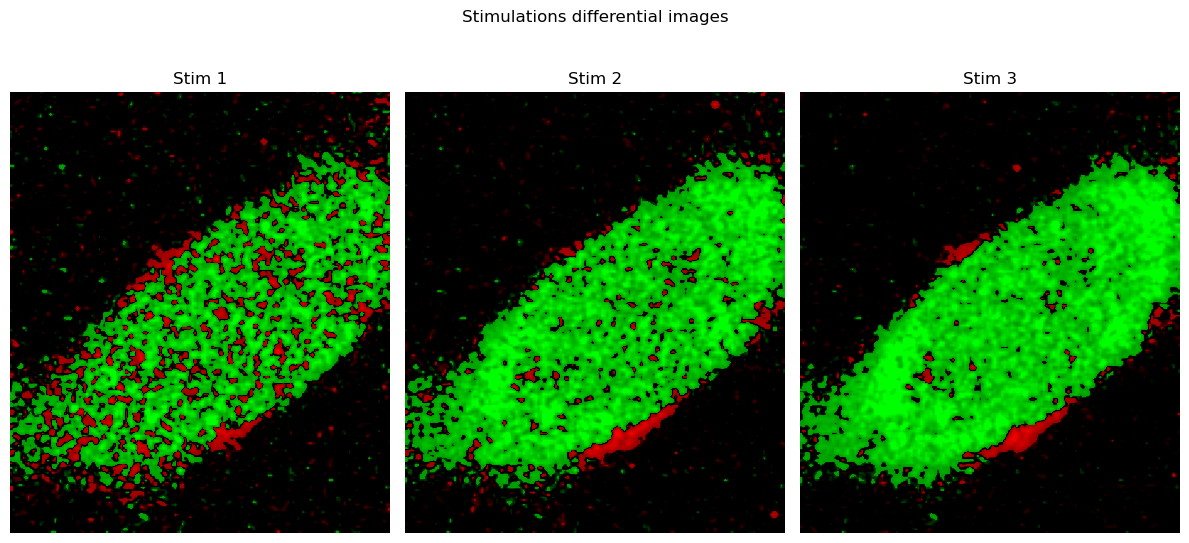

In [21]:
# обчислення та нормалізація диференційних зображень транслокації після кожної стимуляції
diff_stm1 = fp_stm1 - fp_base
diff_stm1 = diff_stm1 / np.max(np.abs(diff_stm1))

diff_stm2 = fp_stm2 - fp_base
diff_stm2 = diff_stm2 / np.max(np.abs(diff_stm2))

diff_stm3 = fp_stm3 - fp_base
diff_stm3 = diff_stm3 / np.max(np.abs(diff_stm3)) 


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(131)
ax0.imshow(diff_stm1, vmin=-0.5, vmax=0.5, cmap=cmap_red_green)
ax0.set_title('Stim 1')
ax0.axis('off')

ax1 = plt.subplot(132)
ax1.imshow(diff_stm2, vmin=-0.5, vmax=0.5, cmap=cmap_red_green)
ax1.set_title('Stim 2')
ax1.axis('off')

ax2 = plt.subplot(133)
ax2.imshow(diff_stm3, vmin=-0.5, vmax=0.5, cmap=cmap_red_green)
ax2.set_title(f'Stim 3')
ax2.axis('off')

plt.suptitle('Stimulations differential images')
plt.tight_layout()
plt.show()

#### Побудова масок регіонів транслокації

Побудова масок регіонів збільшення інтенсивності (__up mask__)

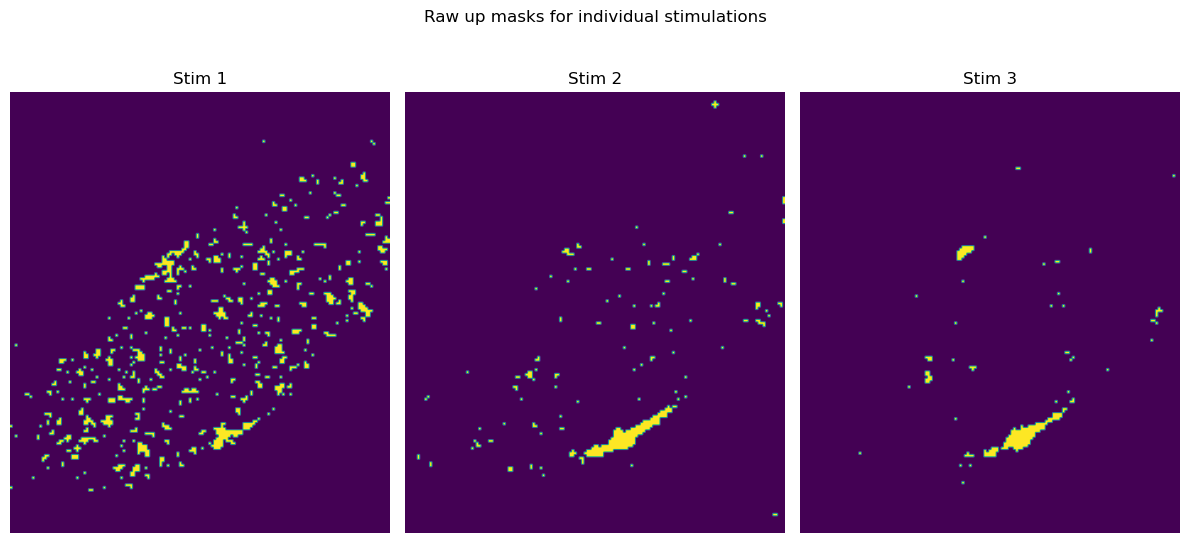

In [22]:
# поріг мінімальної інтенсивності диференційних зображень стимулцій для детекції регіонів збільшення інтенсивності
up_threshold = 0.1

up_mask_stm1_raw = diff_stm1 >= up_threshold
up_mask_stm2_raw = diff_stm2 >= up_threshold
up_mask_stm3_raw = diff_stm3 >= up_threshold


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(131)
ax0.imshow(up_mask_stm1_raw)
ax0.set_title('Stim 1')
ax0.axis('off')

ax1 = plt.subplot(132)
ax1.imshow(up_mask_stm2_raw)
ax1.set_title('Stim 2')
ax1.axis('off')

ax2 = plt.subplot(133)
ax2.imshow(up_mask_stm3_raw)
ax2.set_title(f'Stim 3')
ax2.axis('off')

plt.suptitle('Raw up masks for individual stimulations')
plt.tight_layout()
plt.show()

Фільтрація та модифікація __up mask__

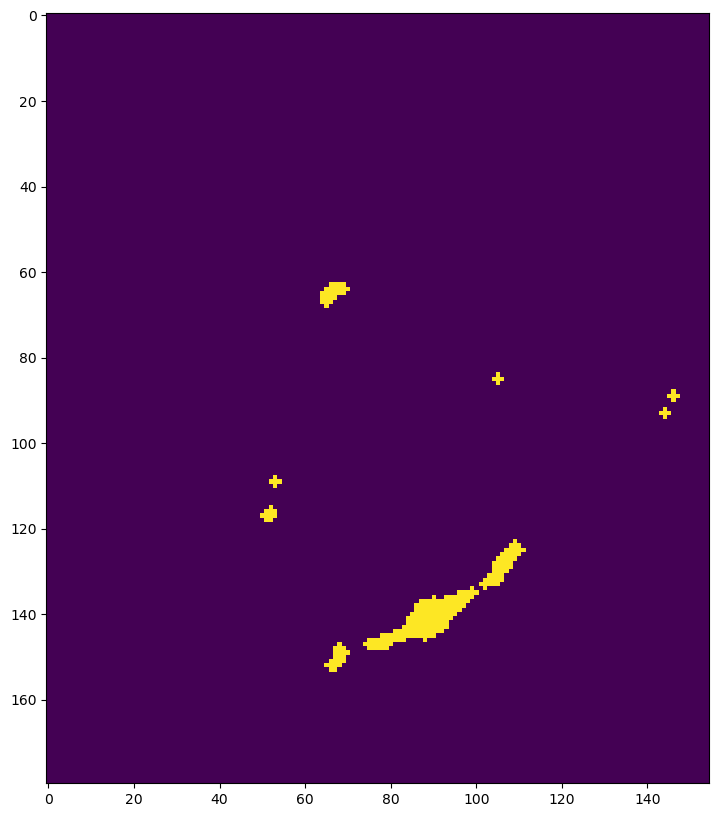

In [23]:
def up_filtering(input_mask, cls_size=5, op_size=1):
    """ Функція для фільтрації маски регіонів транслокації послідовним морфологічними відкриванням та закриванням.

    Input:
      input_mask : boolean numpy array, вхідна макска
      cls_size : int, розмір структурного елементу для морфологічного закривання в пікселях
      op_size : int, розмір структурного елементу для морфологічного відкривання в пікселях

    Output:
      output_mask : boolean numpy array, модифікована булева маска

    """
    output_mask = morphology.closing(input_mask, footprint=morphology.disk(cls_size))
    output_mask = morphology.opening(output_mask, footprint=morphology.disk(op_size))

    return output_mask 

up_mask = up_filtering(up_mask_stm3_raw)


# plot
plt.figure(figsize=(10,10))
plt.imshow(up_mask)

Побудова маски регіонів зменшення інтенсивності (__down mask__)

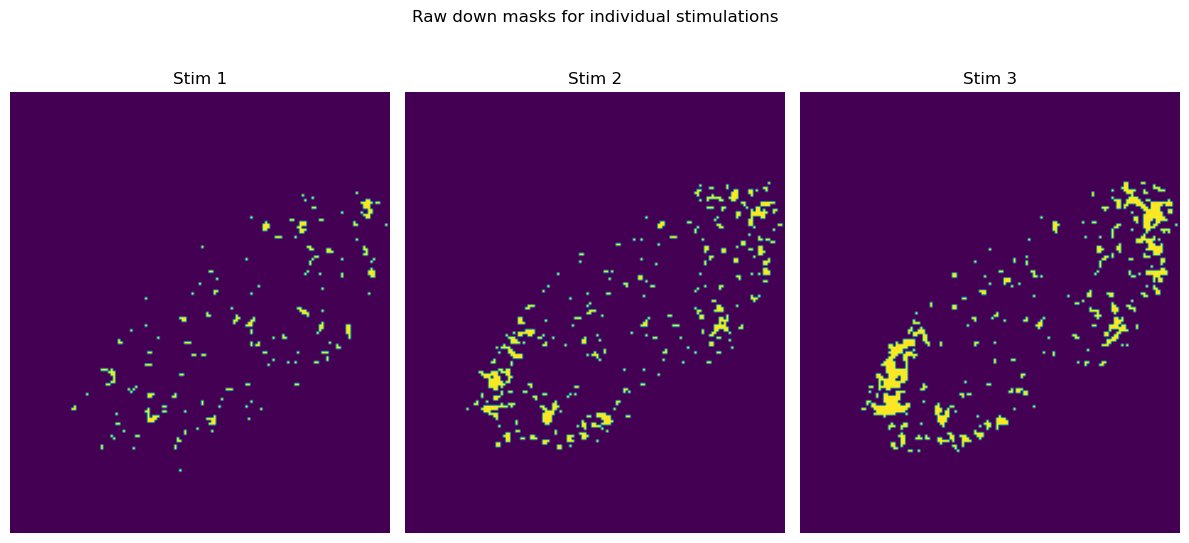

In [24]:
# поріг мінімальної інтенсивності диференційних зображень стимулцій для детекції регіонів зменшення інтенсивності
down_threshold = -0.5  

down_mask_stm1_raw = diff_stm1 <= down_threshold
down_mask_stm2_raw = diff_stm2 <= down_threshold
down_mask_stm3_raw = diff_stm3 <= down_threshold


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(131)
ax0.imshow(down_mask_stm1_raw)
ax0.set_title('Stim 1')
ax0.axis('off')

ax1 = plt.subplot(132)
ax1.imshow(down_mask_stm2_raw)
ax1.set_title('Stim 2')
ax1.axis('off')

ax2 = plt.subplot(133)
ax2.imshow(down_mask_stm3_raw)
ax2.set_title(f'Stim 3')
ax2.axis('off')

plt.suptitle('Raw down masks for individual stimulations')
plt.tight_layout()
plt.show()

# 5. Побудова профілів за масками
---

## Приклади

- Маскування з використання numpy ma
- Усереднення за масками та побудова профілів
- Відносна інтенсивність. dF/F
- морфологіна зв'язність окремих фрагментів маски. label


## Аналіз даних

#### Побудудова профілів зміник концентрації іонів кальцію

Маскування зображення за допомогою __numpy.ma__

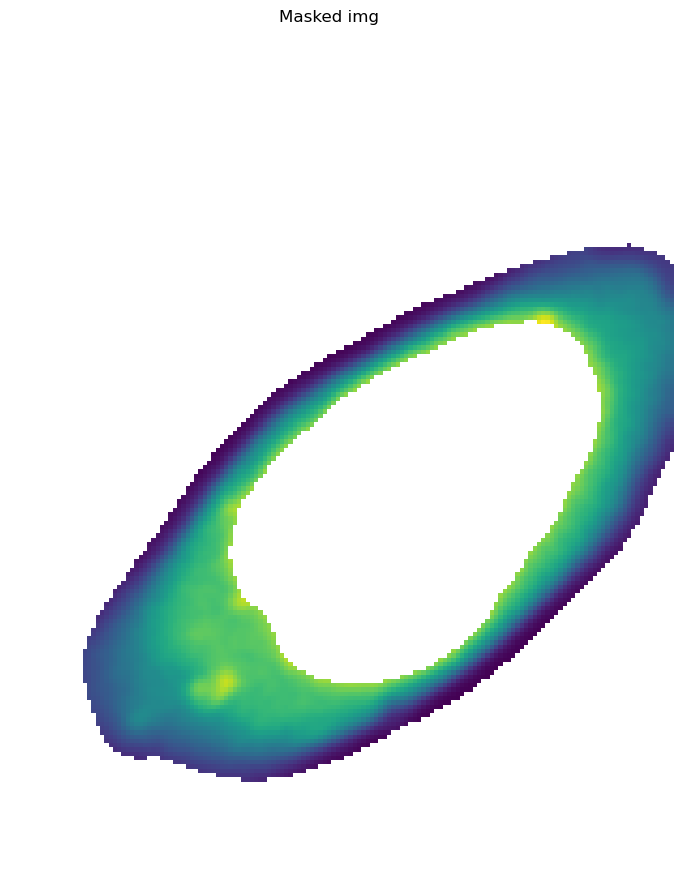

In [25]:
masked = ma.masked_where(~cytoplasm_mask, cell_det_img)  # маскування цитоплазматичного регіону на прикладі контрольного зображення каналу кальцієвго барвника


# plot
plt.figure(figsize=(10,10))
plt.imshow(masked)  # цитоплазамтичний регіон контрольного зображення канала кальцієвого барвника
plt.suptitle('Masked img')
plt.axis('off')
plt.show()

Маскування всієї серії зображень

Порівняння профілів інтенсивності кальцієвого барвника по всій площі клітини та тільки в цитоплазматичному регіоні

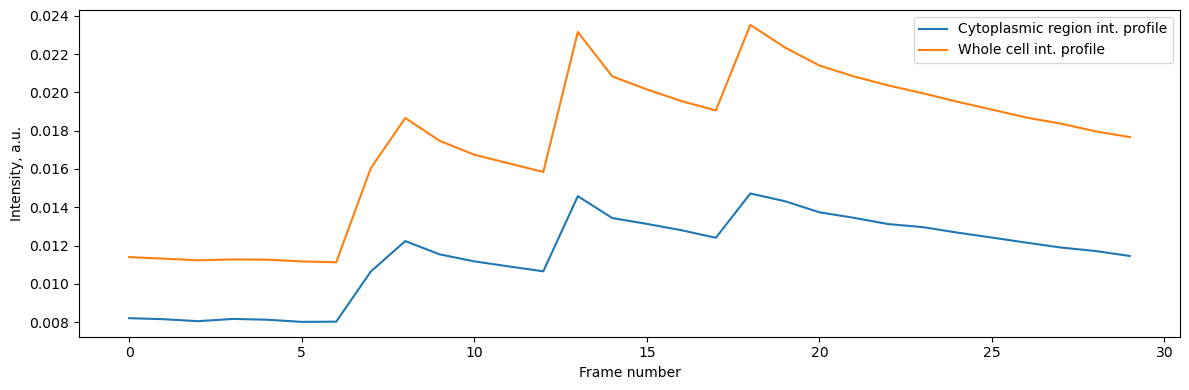

In [26]:
# маскування серії з використанням циклу for
ch0_cytoplasm_prof = []
for img in ch0_img_filtered:
    masked_img = ma.masked_where(~cytoplasm_mask, img)
    masked_img_mean = np.mean(masked_img)
    ch0_cytoplasm_prof.append(masked_img_mean)
ch0_cytoplasm_prof = np.asarray(ch0_cytoplasm_prof)

# маскування з використанням list comprechension
ch0_cell_prof = np.asarray([np.mean(ma.masked_where(~cell_mask, img)) for img in ch0_img_filtered])


# plot
plt.figure(figsize=(12, 4))

plt.plot(ch0_cytoplasm_prof, label='Cytoplasmic region int. profile') # профіль похідної інтенсивності для канала 0
plt.plot(ch0_cell_prof, label='Whole cell int. profile') # профіль похідної інтенсивності для канала 0

plt.xlabel('Frame number')
plt.ylabel('Intensity, a.u.')

plt.legend()
plt.tight_layout()
plt.show()

Перехід від абсолютної до відносної інтенсивності. ΔF/F

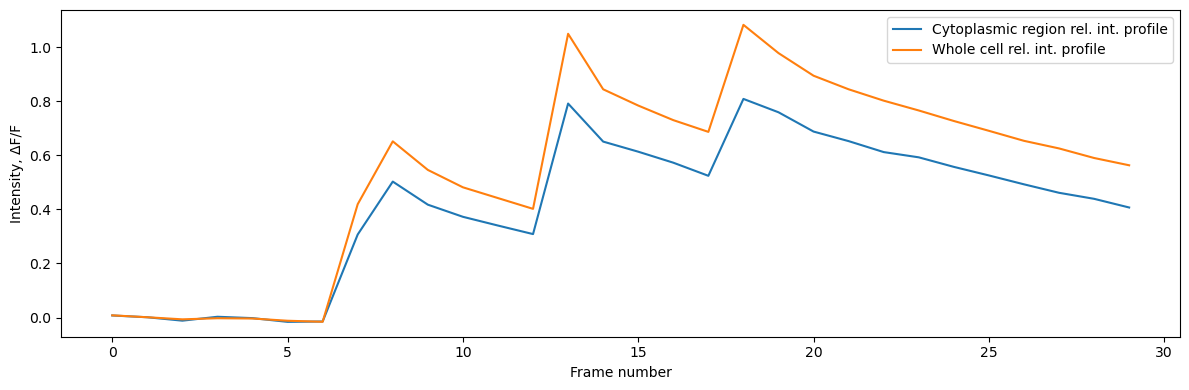

In [27]:
ch0_f0_win = 4  # кількість точок профіля за якими обчислюється початкова інтенсивність F0

# обчислення відносної інтенсивності для профіля інтенсивності кальцієвого барвника в цитоплазматичному регіоні
ch0_cytoplasm_f0 = np.mean(ch0_cytoplasm_prof[:ch0_f0_win])
ch0_cytoplasm_dF_prof = np.asarray((ch0_cytoplasm_prof - ch0_cytoplasm_f0) / ch0_cytoplasm_f0)

# обчислення відносної інтенсивності для профіля інтенсивності кальцієвого барвника по всій площі клітини
ch0_cell_f0 = np.mean(ch0_cell_prof[:ch0_f0_win])
ch0_cell_dF_prof = np.asarray((ch0_cell_prof - ch0_cell_f0) / ch0_cell_f0)


# plot
plt.figure(figsize=(12, 4))

plt.plot(ch0_cytoplasm_dF_prof, label='Cytoplasmic region rel. int. profile')
plt.plot(ch0_cell_dF_prof, label='Whole cell rel. int. profile')

plt.xlabel('Frame number')
plt.ylabel('Intensity, ΔF/F')

plt.legend()
plt.tight_layout()
plt.show()

#### Побудова профілів вбудовування за __up mask__

Побудова профілів для загальної __up mask__

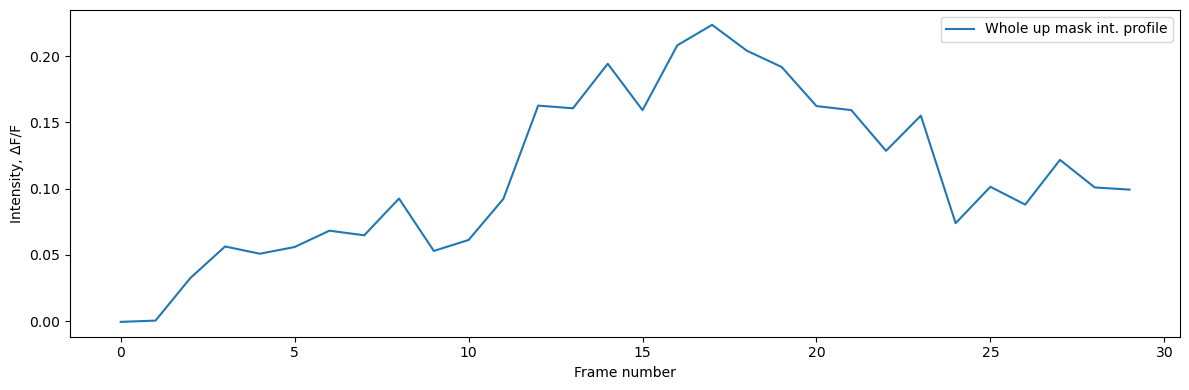

In [28]:
# обчислення профілю середньої інтенстивоті в регіоні up mask для зображень каналу флуоресцентного білка
ch1_up_mask_prof = np.asarray([np.mean(ma.masked_where(~up_mask, img)) for img in ch1_img_filtered])

# обчислення профілю відносної інтенсивності для зображень каналу флуоресцентного білка
ch1_f0_win = 2
ch1_up_mask_f0 = np.mean(ch1_up_mask_prof[:ch1_f0_win])
ch1_up_mask_dF_prof = np.asarray((ch1_up_mask_prof - ch1_up_mask_f0) / ch1_up_mask_f0)


# plot
plt.figure(figsize=(12, 4))

plt.plot(ch1_up_mask_dF_prof, label='Whole up mask int. profile') # профіль похідної інтенсивності для канала 0

plt.xlabel('Frame number')
plt.ylabel('Intensity, ΔF/F')

plt.legend()
plt.tight_layout()
plt.show()

Фрагментація маски регіонів вбудовування __up mask__

9


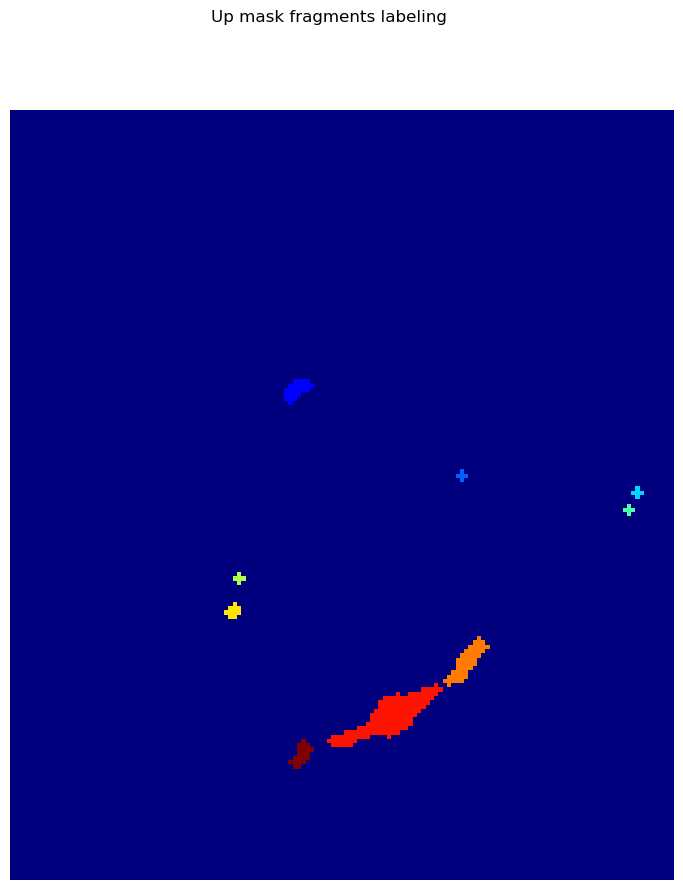

In [29]:
up_labels = measure.label(up_mask)
print(up_labels.max())

# plot
plt.figure(figsize=(10,10))
plt.imshow(up_labels, cmap='jet')  # промарковані окремі фрагменти up mask
plt.suptitle('Up mask fragments labeling')
plt.axis('off')
plt.show()

Побудова профілів для кожного фрагменту __up mask__ окремо

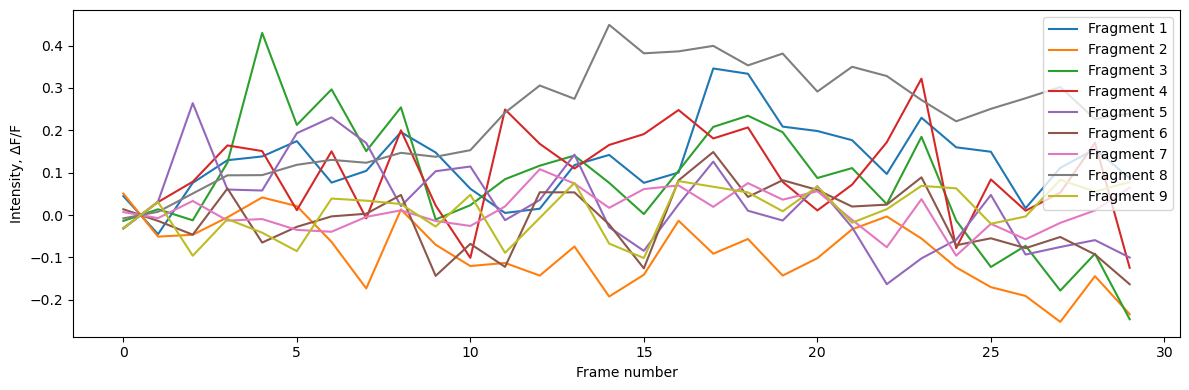

In [37]:
plt.figure(figsize=(12, 4))  # ініціалізація графіку для подальшого оновлення в циклі for

# цикл for по окремих фрагментах
ch1_up_fragments_dF_prof_list = []  # порожній список в якому будуть зберігатися профілі віндонсної інтенсивності кожного фрегмента up mask
for up_fragment_num in range(1, up_labels.max()+1):
    up_fragment_mask = up_labels == up_fragment_num  # створення маски окремого фрагменту up mask

    ch1_up_fragment_prof = np.asarray([np.mean(ma.masked_where(~up_fragment_mask, img)) for img in ch1_img_filtered])  # обчислення профілю інтенсивності за маскою

    ch1_up_fragment_f0 = np.mean(ch1_up_fragment_prof[:ch1_f0_win])
    ch1_up_fragment_dF_prof = np.asarray((ch1_up_fragment_prof - ch1_up_fragment_f0) / ch1_up_fragment_f0)

    ch1_up_fragments_dF_prof_list.append(ch1_up_fragment_dF_prof) 

    plt.plot(ch1_up_fragment_dF_prof, label=f'Fragment {up_fragment_num}')  # додавання профілю до існуючого графіку

ch1_up_fragments_dF_prof_arr = np.asarray(ch1_up_fragments_dF_prof_list)

plt.xlabel('Frame number')
plt.ylabel('Intensity, ΔF/F')

plt.legend()
plt.tight_layout()
plt.show()

#### Побудова профілю дозо-залежності вбудовування від внутрішньоклітинної концентрації іонів кальцію

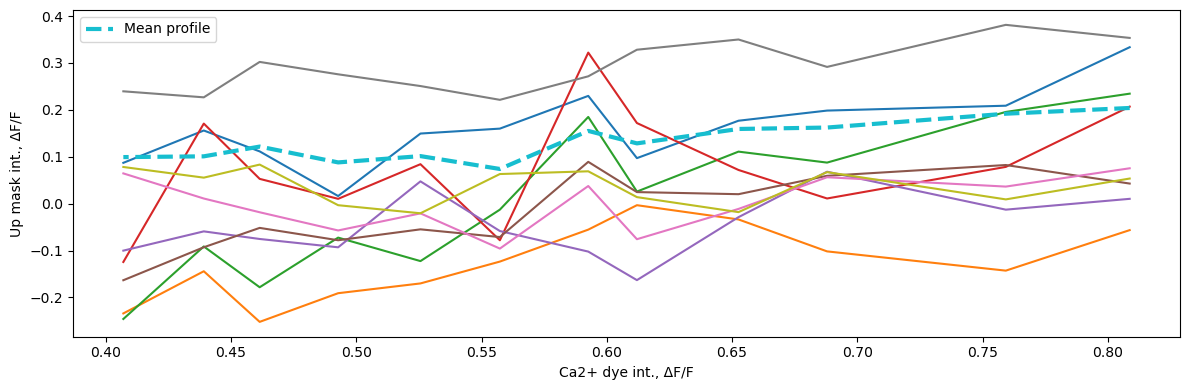

In [36]:
ca_tail_start_idx = 18  # індекс початку спаду інтенсинвості кальцієвого барвника після останньої стимуляції



# plot
plt.figure(figsize=(12, 4))

for one_ch1_prof in ch1_up_fragments_dF_prof_list:  # відображення дозо-залежностей для профілю кожного окремого фрагменту up mask
    plt.plot(ch0_cytoplasm_dF_prof[18:], one_ch1_prof[ca_tail_start_idx:])

plt.plot(ch0_cytoplasm_dF_prof[18:], ch1_up_mask_dF_prof[ca_tail_start_idx:],
         linestyle='--', linewidth=3, label='Mean profile')

plt.xlabel('Ca2+ dye int., ΔF/F')
plt.ylabel('Up mask int., ΔF/F')

plt.legend()
plt.tight_layout()
plt.show()

# 6. Оцінка параметрів за допомогою лінійної моделі
---

## Приклади

- Лінійна модель на її коефіцієнти
- Оцінка параметрів лінійною моделі

## Аналіз даних

#### Лінеарізація кривої дозо-залежності

R-squared: 0.679043


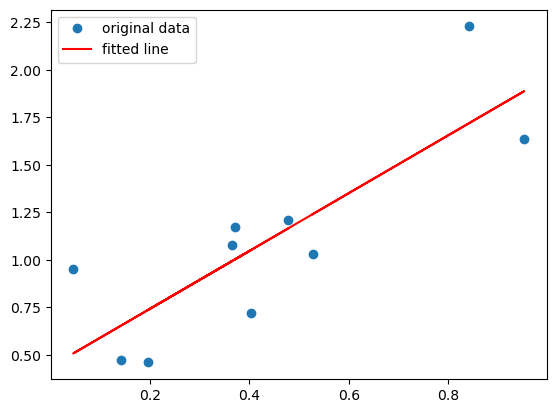

slope (95%): 1.520791 +/- 0.852432
intercept (95%): 0.438221  +/- 0.436275


In [28]:
import numpy as np

import matplotlib.pyplot as plt

from scipy import stats

rng = np.random.default_rng()


x = rng.random(10)

y = 1.6*x + rng.random(10)


res = stats.linregress(x, y)


print(f"R-squared: {res.rvalue**2:.6f}")


plt.plot(x, y, 'o', label='original data')

plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')

plt.legend()

plt.show()



from scipy.stats import t

tinv = lambda p, df: abs(t.ppf(p/2, df))

ts = tinv(0.05, len(x)-2)

print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")

print(f"intercept (95%): {res.intercept:.6f}", f" +/- {ts*res.intercept_stderr:.6f}")

#### Визначення коефіцієнтів лінійної моделі (fitting)

In [ ]:
img_raw = io.imread('post_rgeco_mov_cor.tif')
img_bad = io.imread('post_rgeco.tif')

plt.figure(figsize=(10,10))
plt.imshow(np.max(img_bad, axis=0), cmap='jet')

plt.figure(figsize=(10,10))
plt.imshow(np.max(img_raw, axis=0), cmap='jet')

img = np.array([filters.gaussian(frame) for frame in img_raw])

print(img.shape)

In [ ]:
th_y = filters.threshold_yen(np.max(img, axis=0))
th_o = filters.threshold_otsu(np.max(img, axis=0))
th_l = filters.threshold_li(np.max(img, axis=0))

print(th_y, th_o, th_l)


img_max = np.max(img, axis=0)
plt.figure(figsize=(10,10))
plt.imshow(img_max, cmap='jet')

mask = img_max > th_y
crop_mask = mask[100:200, 100:200]
plt.figure(figsize=(10,10))
plt.imshow(mask)

label_mask = measure.label(mask)
plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap='jet')

In [ ]:
area_dict = {}
area_th = 150
for label_number in range(1, np.max(label_mask)):
    one_label_mask = label_mask == label_number
    one_label_area = np.sum(one_label_mask)
    
    if one_label_area >= area_th:
        label_area_dict = {label_number:one_label_area}
        area_dict.update(label_area_dict)

fin_mask = np.zeros_like(label_mask)
for lable_key in area_dict.keys():
     key_mask = label_mask == lable_key
     fin_mask = fin_mask + key_mask

fin_raw_mask = fin_mask
fin_mask = morphology.dilation(fin_mask, footprint=morphology.disk(6))
# plt.imshow(fin_raw_mask)
plt.figure(figsize=(10,10))
plt.imshow(fin_mask)


fin_mask = measure.label(fin_mask)
plt.figure(figsize=(10,10))
plt.imshow(fin_mask)

#### Watershed segmentation

In [ ]:
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

distance = ndi.distance_transform_cdt(fin_mask, metric='taxicab')
plt.figure(figsize=(10,10))
plt.imshow(distance)

# ndi.distance_transform_cdt, metric='taxicab'

coords = peak_local_max(distance, min_distance=15, footprint=morphology.disk(15), labels=fin_mask)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=fin_mask)

plt.figure(figsize=(10,10))
plt.imshow(labels)

#### Profiles extration

In [ ]:
# profile = [np.mean(ma.masked_where(-fin_mask, frame)) for frame in img_raw]

plt.figure(figsize=(20, 8))

prof_arr = []
i = 0
for label in range(1, np.max(labels)+1):
    mask = labels == label
    prof = [np.mean(ma.masked_where(~mask, frame)) for frame in img_raw]
    prof_arr.append(prof)
    plt.plot(prof, label=label)
    i += 200

plt.legend()
plt.show()

prof_arr = np.asarray(prof_arr)

print(prof_arr.shape)


#### Demo labeling

In [ ]:
demo_mask = np.array([[1, 0, 1, 0],
                      [0, 0, 1, 1],
                      [0, 1, 0, 0],
                      [1, 0, 1, 0]])

label_demo_mask = measure.label(demo_mask, connectivity=1)

print(demo_mask)
print(label_demo_mask)
plt.imshow(label_demo_mask)

#### Peaks detection

In [ ]:
one_profile = dF_prof_arr[2]

peaks, properties = signal.find_peaks(one_profile,
                                      height=0.2,
                                      distance=5,
                                      wlen=30,
                                      prominence=0.15,
                                      rel_height=0.5,
                                      width=1)

print(peaks)
print(properties.keys())
print(properties)

In [ ]:

plt.figure(figsize=(20, 8))
plt.plot(one_profile)
plt.plot(peaks, one_profile[peaks], 'x')
